# Generate and plot QCD multijets

Here we use pythia to generate some multijet events and then use coffea to histogram and plot them. 

## Generate events

Uncomment the next cell to generate the events right from here (only do once). 

*IMPORTANT* : If you do execute this, you need to set up ROOT before launching `jupyter` like

```
source setup.sh
source launch.sh
```

In [1]:
#! pythia2root qcd_multijets.cfg qcd_multijets.root 10000 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.306      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 28 Jun 2021  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    H   H  III  A   A    Now is 25 May 2022 at 20:20:25    |  | 
 |  |                                                                              |  | 
 |  |   Program docu


 --------  PYTHIA Info Listing  ---------------------------------------- 
 
 Beam A: id =   2212, pz =  7.000e+03, e =  7.000e+03, m =  9.383e-01.
 Beam B: id =   2212, pz = -7.000e+03, e =  7.000e+03, m =  9.383e-01.

 In 1: id =   -2, x =  4.222e-02, pdf =  1.830e-01 at Q2 =  2.964e+04.
 In 2: id =   21, x =  1.071e-01, pdf =  7.556e-01 at same Q2.

 Subprocess q g -> q g with code 113 is 2 -> 2.
 It has sHat =  8.863e+05,    tHat = -3.071e+04,    uHat = -8.556e+05,
       pTHat =  1.722e+02,   m3Hat =  3.300e-01,   m4Hat =  0.000e+00,
    thetaHat =  3.744e-01,  phiHat =  1.509e+00.
     alphaEM =  7.874e-03,  alphaS =  1.181e-01    at Q2 =  2.964e+04.

 Impact parameter b =  8.901e-01 gives enhancement factor =  8.890e-01.
 Max pT scale for MPI =  1.722e+02, ISR =  1.722e+02, FSR =  1.722e+02.
 Number of MPI =     4, ISR =     4, FSRproc =    53, FSRreson =     0.

 --------  End PYTHIA Info Listing  ------------------------------------

 --------  PYTHIA Event Listing  (hard proc

 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  
 PYTHIA Warning in StringFragmentation::fragmentToJunction: bad convergence junction rest frame  
 PYTHIA Error in SimpleSpaceShower::pT2nearThreshold: stuck in loop  

 Pythia::next(): 1000 events have been generated 
 PYTHIA Warning in Pythia::check: not quite matched particle energy/momentum/mass  

 Pythia::next(): 2000 events have been generated 

 Pythia::next(): 3000 events have been generated 
 PYTHIA Error in StringFragmentation::fragmentToJunction: caught in junction flavour loop  
 PYTHIA Warning in SimpleSpaceShower::pT2nextQCD: weight above unity  

 Pythia::next(): 4000 events have been generated 

 Pythia::next(): 5000 events have been generated 

 Pythia::next(): 6000 events have been generated 

 Pythia::next(): 7000 events have been generated 

 Pythia::next(): 8000 events have been generated 

 Pythia::next(): 9000 events have been generat

In [2]:
import awkward as ak
from coffea import hist, processor
import numpy as np

# register our candidate behaviors
from coffea.nanoevents.methods import candidate
ak.behavior.update(candidate.behavior)

In [9]:
class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        self._accumulator = processor.dict_accumulator({
            "sumw": processor.defaultdict_accumulator(float),
            "jet_pt": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("pt", "$p_{T}$ [GeV]", 100, 0, 1000),
            ),
            "jet_eta": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("eta", "$\eta$", 100, -np.pi, np.pi),
            ),
            "jet_m": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("mass", "Mass [GeV]", 20, 0, 200),
            ),
            "jet_msd": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("msd", "Groomed mass [GeV]", 20, 0, 200),
            ),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        output = self.accumulator.identity()

        dataset = events.metadata['dataset']
        jets = ak.zip({
            "pt": events.jet_pt,
            "eta": events.jet_eta,
            "phi": events.jet_phi,
            "mass": events.jet_m,
            "msd": events.jet_msd,
        }, with_name="PtEtaPhiMCandidate")
        
        jets = jets[ak.num(jets) > 0]

        output["sumw"][dataset] += len(events)
        output["jet_pt"].fill(
            dataset=dataset,
            pt=ak.flatten(jets.pt),
        )        
        output["jet_eta"].fill(
            dataset=dataset,
            eta=ak.flatten(jets.eta),
        )
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [10]:
import time

tstart = time.time()

fileset = {
    'QCD': [
        'qcd_multijets.root'
    ]
}

output = processor.run_uproot_job(
    fileset,
    treename='T',
    processor_instance=MyProcessor(),
    executor=processor.futures_executor,
    executor_args={"workers": 4},
    chunksize=10000,
    maxchunks=None,
)

elapsed = time.time() - tstart
print(output)

Processing:   0%|          | 0/1 [00:00<?, ?chunk/s]

/usr/local/lib/python3.8/dist-packages/coffea/nanoevents/mapping/uproot.py:89: UserWarning: Skipping jet_tau1 as it is not interpretable by NanoEvents
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/coffea/nanoevents/mapping/uproot.py:89: UserWarning: Skipping jet_tau2 as it is not interpretable by NanoEvents
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/coffea/nanoevents/mapping/uproot.py:89: UserWarning: Skipping jet_tau3 as it is not interpretable by NanoEvents
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/coffea/nanoevents/mapping/uproot.py:89: UserWarning: Skipping jet_tau4 as it is not interpretable by NanoEvents
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/coffea/nanoevents/mapping/uproot.py:89: UserWarning: Skipping jet_tau5 as it is not interpretable by NanoEvents
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/coffea/nanoevents/mapping/uproot.py:89: UserWarning: Skipping jet_tau6 as it is not interpretable by NanoEvents
  warning

{'sumw': defaultdict_accumulator(<class 'float'>, {'QCD': 10000.0}), 'jet_pt': <Hist (dataset,pt) instance at 0x7fc1ce106250>, 'jet_eta': <Hist (dataset,eta) instance at 0x7fc1ce0fd280>, 'jet_m': <Hist (dataset,mass) instance at 0x7fc1ce0fd2b0>, 'jet_msd': <Hist (dataset,msd) instance at 0x7fc1ce0fd550>}


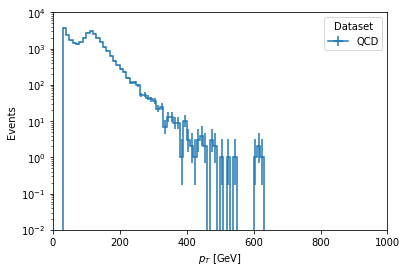

In [11]:
ax = hist.plot1d(output["jet_pt"], overlay='dataset')
ax.set_ylim((1e-2,1e4))
ax.set_yscale("log")